In [73]:
from math import exp, sqrt, sin, cos
import itertools
import csv

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.signal import hilbert, chirp
from scipy.optimize import fsolve

In [6]:
def arrays_to_csv(array1, array2, name):
    with open(f"{name}.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for a1, a2 in zip(array1, array2):
            writer.writerow([round(a1, 5), a2])

## Konstante i osnovne funkcije

In [13]:
kb = 8.6173303 * 10 ** (-5)
hbar = 6.582119569 * 10 ** (-16)
pi = np.pi

alpha_op = 0.4
alpha_ac = 1
hbar_w_op = 0.02
eta_0 = 5 * 10 ** (-3)
M = 0.0
Kf = 0.25  # eV
Kf_20 = 0.26  # 20K
vf = 4 * 10**5
a = 100 ** (1 / 3) * 10 ** (-10)
T_0 = 20


Ef = sqrt(Kf_20**2 + M**2)
Kf_ = Kf_20 / hbar / vf * a  # unitless
Kf_max = 8 * Kf_
hbar_w_ac = 0.01 / Kf_max
G_op2 = alpha_op
G_ac2 = alpha_ac * hbar * vf / a

print(G_ac2)
print(hbar_w_ac)
print(Ef)

0.5672298693356524
0.002727066679498329
0.26


In [8]:
def fermi_dirac(E, Ef, T):
    if T > 0:
        if E > Ef:
            return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
        else:
            return 1 / (exp((E - Ef) / (kb * T)) + 1)
    else:
        if E > Ef:
            return 0
        else:
            return 1


def bose_einstein(E, T):
    assert T > 0
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)


def chemical_potential(T):
    return (
        Ef
        - pi**2 / 6 * (2 * Ef**2 - M**2) / Ef / (Ef**2 - M**2) * (kb * T) ** 2
        - 7 / 360 * pi**4 * 3 * M**4 / Ef / (Ef**2 - M**2) ** 3 * (kb * T) ** 4
    )  # Sommerfield approx.


#    return abs(fsolve(particle_density_int, 0.55, args=(M,Kf,T))[0]) # use this for exact value


def particle_density(E, Ef, M, T):
    g = E * sqrt(E**2 - M**2) / pi**2 / (hbar * vf) ** 3
    fs = -fermi_dirac(E, -Ef, T) + fermi_dirac(E, Ef, T)
    return g * fs


def particle_density_int(u, M, Kf, T):
    na = 1 / 3 / pi**2 * Kf**3 / (vf * hbar) ** 3
    return na - integrate.quad(particle_density, M, 7, args=(u, M, T), limit=80000)[0]


def eps(K):
    return sqrt(hbar**2 * vf**2 / a**2 * K**2 + M**2)  # K dimensionless

## Optički fononi


In [71]:
def ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        return (
            bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)
        ) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j)

    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2


def ss_sum_real(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).real


def ss_sum_imag(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).imag


def mem_fn(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integral_k = integrate.quad(
        ss_sum_fn, 0, Kf_ * 4.0, args=(hbar_w, hbar_w_ph, T, u, eta), limit=80000
    )[0]
    return (
        -G_op2 * integral_k / (2 * pi) ** 2 * 2
    )  # one factor 2 for 4\pi and one for two bands

**Memorijska funkcija**

In [79]:
ws_0 = np.arange(0, 0.25, 0.0001)



def calculate_integral_points(mem_fn, T=T_0, eta=eta_0, ws=ws_0):

    result_real = []

    result_imag = []

    for w in ws:

        result_real.append(
            mem_fn(
                ss_sum_real,
                hbar_w=w,
                hbar_w_ph=hbar_w_op,
                u=Kf_20,  # chemical_potential(T),
                T=T,
                eta=eta,
            )
        )

        result_imag.append(
            mem_fn(
                ss_sum_imag,
                hbar_w=w,
                hbar_w_ph=hbar_w_op,
                u=Kf_20,  # chemical_potential(T),
                T=T,
                eta=eta,
            )
        )

    return result_real, result_imag



def setup_plot(real=True, imag=True, x_lim=[0.0, 0.05], y_lim=[0.0, 0.06]):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel(r"$\hbar \omega [eV]$")

    if real:

        ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$")

    else:

        ax1.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax1.set_xlim(x_lim)

    ax1.set_ylim(y_lim)


    ax2 = ax1.twinx()

    if imag and real:

        ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax2.set_xlim(x_lim)

    ax2.set_ylim(y_lim)


    return fig, ax1, ax2



def plot_real_and_imag_result(
    ax1, ax2, result_real, result_imag, T=None, eta=None, ws=ws_0
):
    assert T or eta


    ax1.plot(ws, result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")

    ax2.plot(ws, result_imag)

    if T:

        plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)

    else:

        plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)



def plot_result(ax, result, T=None, eta=None, ws=ws_0):

    ax.plot(ws, result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")

<>:79: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\e'
<>:79: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_11296\764490954.py:79: SyntaxWarning: invalid escape sequence '\e'
  ax1.plot(ws, result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")
C:\Users\Patrik\AppData\Local\Temp\ipykernel_11296\764490954.py:85: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
C:\Users\Patrik\AppData\Local\Temp\ipykernel_11296\764490954.py:95: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(ws, result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")


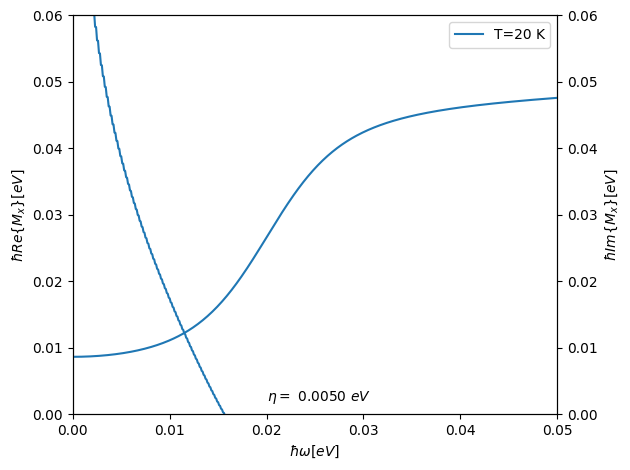

In [80]:
fig, *axs = setup_plot()
integrals = calculate_integral_points(mem_fn)
real_to_plot = hilbert(integrals[1])
# arrays_to_csv(ws_0, integrals[0], f"op, real, K_max=4.0K_f, T=20K, eta={eta_0}eV")
# arrays_to_csv(ws_0, integrals[1], f"op, imag, K_max=4.0K_f, T=20K, eta={eta_0}eV")
plot_real_and_imag_result(
    *axs, result_real=np.imag(real_to_plot), result_imag=integrals[1], T=T_0
)
axs[0].legend(loc="best")
fig.tight_layout()

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_8488\22505859.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


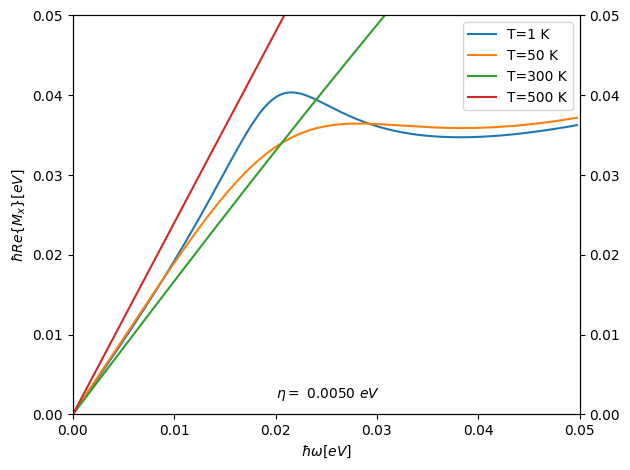

In [ ]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.05])
ws_to_plot = np.arange(0, 0.05, 0.00025)
for T in [1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T, ws=ws_to_plot)
    plot_result(axs[0], integrals[0], T=T, ws=ws_to_plot)
    arrays_to_csv(ws_to_plot, integrals[0], f"op, T={T}K, eta={eta_0}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_8488\3542236707.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


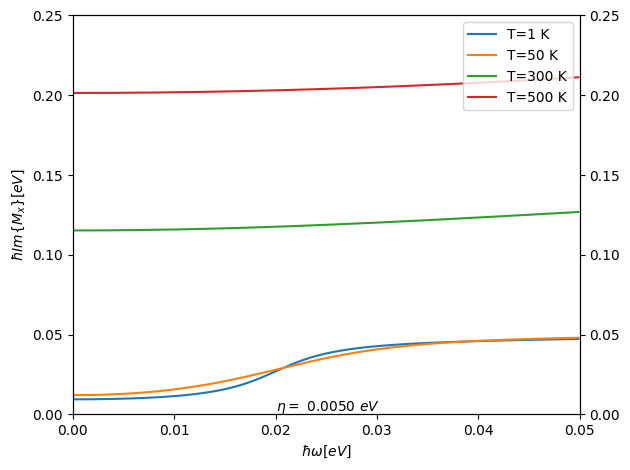

In [ ]:
fig, *axs = setup_plot(real=False, y_lim=[0, 0.25])
for T in [1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T)
    plot_result(axs[0], integrals[1], T=T)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

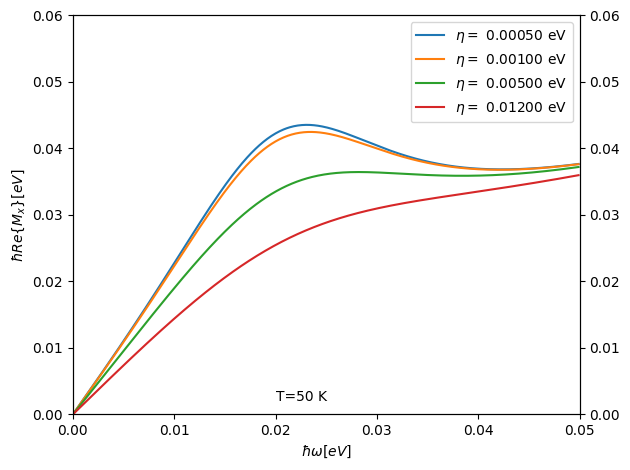

In [ ]:
fig, *axs = setup_plot(imag=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[0], eta=eta)
    arrays_to_csv(ws_0, integrals[0], f"op, T={T_0}K, eta={eta}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()

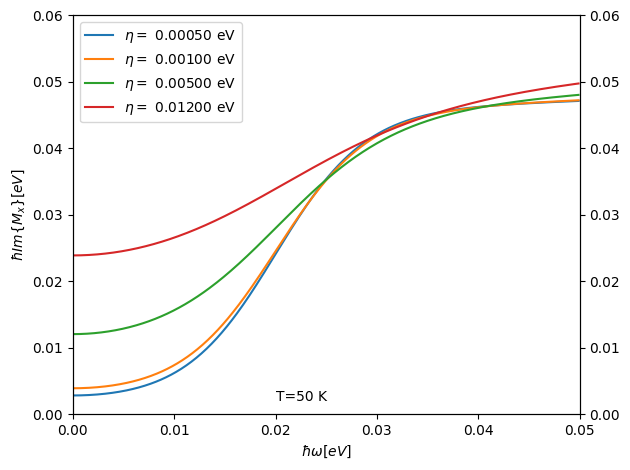

In [ ]:
fig, *axs = setup_plot(real=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[1], eta=eta)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()

Podintegralna funkcija za memorijsku funkciju

In [ ]:
ws = np.arange(0, 1, 0.2)
ks = np.arange(0, Kf_ * 10, 0.001)
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_real(k, w, hbar_w_op, T_0, chemical_potential(T), eta_0)
        ss_sums.append(ss)
    plt.plot(ks, ss_sums, label=f"{w} eV")
plt.legend()

TypeError: ss_sum_real() missing 1 required positional argument: 'eta'

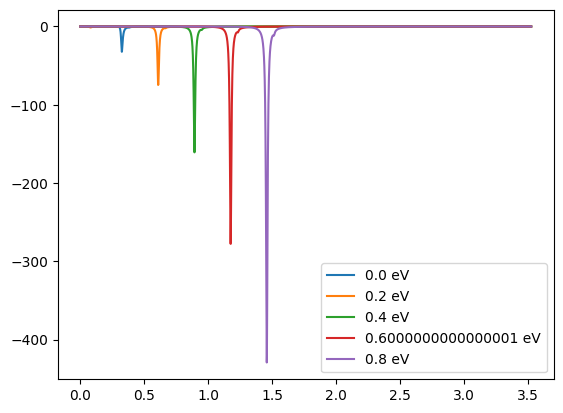

In [ ]:
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_imag(k, w, hbar_w_op, T_0, chemical_potential(T), eta_0)
        ss_sums.append(ss)
    plt.plot(ks, ss_sums, label=f"{w} eV")
plt.legend()

## Akustični fononi

In [ ]:
def ss_sum_part(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        abs_K = sqrt(K**2 + Kf_**2 - 2 * Kf_ * K * cos(theta))
        factor = 1 - K * cos(theta) * Ef / eps(K) / Kf_
        return (
            (
                bose_einstein(hbar_w_ph * abs_K, T)
                + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)
            )
            / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j)
            * abs_K
            * factor
        )

    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * sin(theta)


def ss_sum_real(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, hbar_w, hbar_w_ph, T, u, eta).real


def ss_sum_imag(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, hbar_w, hbar_w_ph, T, u, eta).imag


def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integral_k_theta = integrate.nquad(
        ss_sum_fn,
        ([0, Kf_ * 7], [0, pi]),
        args=(hbar_w, hbar_w_ph, T, u, eta),
        opts={"epsabs": 1.49 * 10 ** (-4), "epsrel": 1.49 * 10 ** (-4)},
    )[0]
    return -G_ac2 * integral_k_theta / (2 * pi) ** 2

**Memorijska funkcija**

/Users/ppapac/git/24112024_memoryfn/.venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


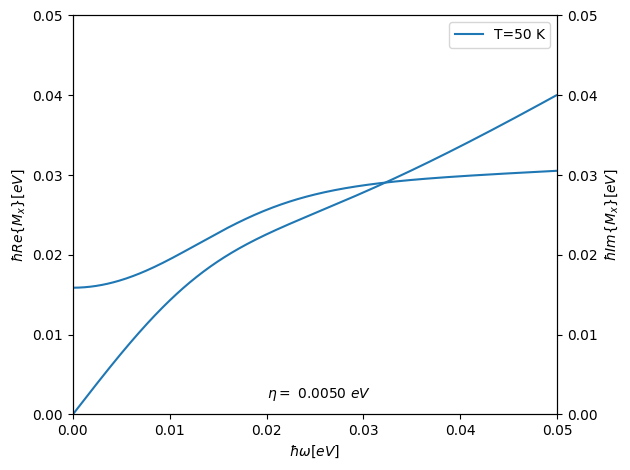

In [ ]:
fig, *axs = setup_plot(y_lim=[0, 0.05])
integrals = calculate_integral_points(mem_fn_ac)
plot_real_and_imag_result(*axs, *integrals, T=T_0)
arrays_to_csv(ws_0, integrals[0], f"ac, T=50K, eta={eta_0}eV")
axs[0].legend(loc="best")
fig.tight_layout()

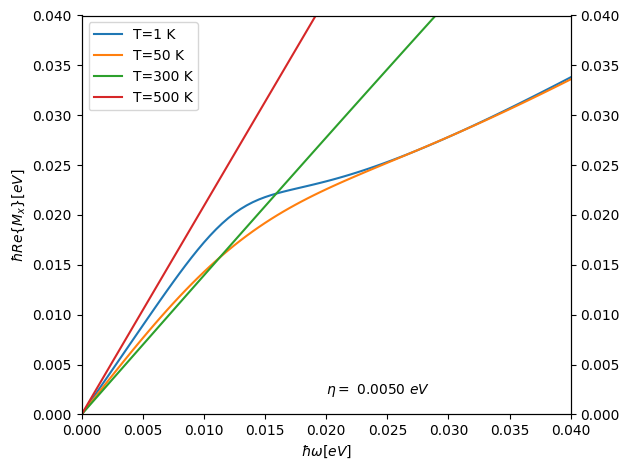

In [ ]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.04], x_lim=[0, 0.04])
w_to_plot = np.arange(0, 0.0401, 0.0005)
for T in [1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=w_to_plot)
    plot_result(axs[0], integrals[0], T=T, ws=w_to_plot)
    arrays_to_csv(w_to_plot, integrals[0], f"ac, T={T}K, eta={eta_0}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

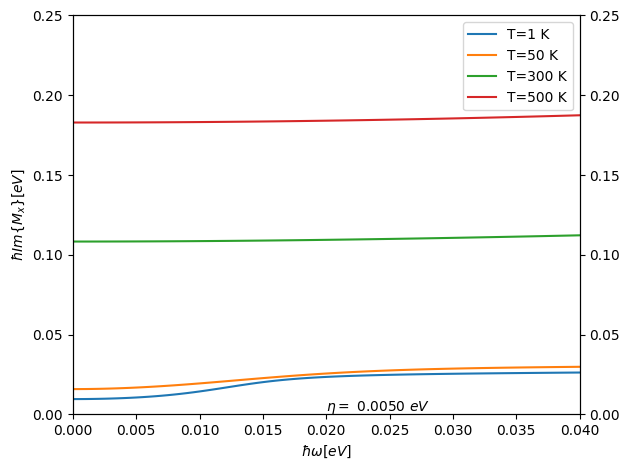

In [ ]:
fig, *axs = setup_plot(real=False, y_lim=[0, 0.25], x_lim=[0, 0.04])
w_to_plot = np.arange(0, 0.0401, 0.0005)
for T in [1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=w_to_plot)
    plot_result(axs[0], integrals[1], T=T, ws=w_to_plot)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

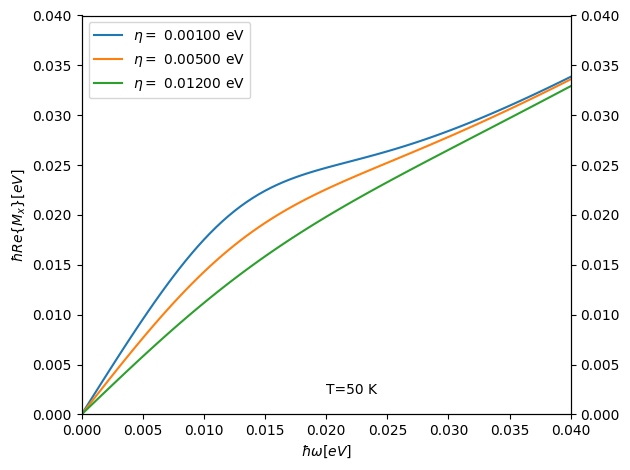

In [ ]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.04], x_lim=[0, 0.04])
w_to_plot = np.arange(0, 0.0401, 0.0005)
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=w_to_plot)
    plot_result(axs[0], integrals[0], eta=eta, ws=w_to_plot)
    arrays_to_csv(w_to_plot, integrals[0], f"ac, T={T_0}K, eta={eta}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()

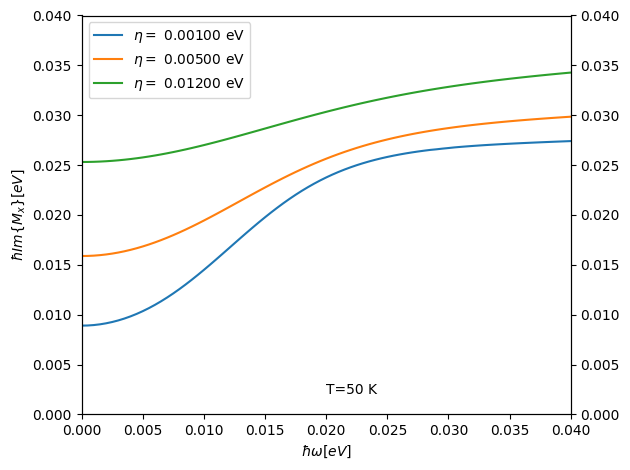

In [ ]:
fig, *axs = setup_plot(real=False, y_lim=[0, 0.04], x_lim=[0, 0.04])
w_to_plot = np.arange(0, 0.0401, 0.0005)
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=w_to_plot)
    plot_result(axs[0], integrals[1], eta=eta, ws=w_to_plot)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()